<a href="https://colab.research.google.com/github/dvaughanCogniCom/jupyter_notebooks/blob/main/Charlotte_Wet_Data_4_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Track Data



In [6]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import io

Saving Charlotte_4_10_2021_A.csv to Charlotte_4_10_2021_A.csv


In [7]:
import matplotlib.pyplot as plt
plt.style.use('classic')

%matplotlib inline
import seaborn as sns
sns.set_theme()

# Create dataframes

In [9]:
import numpy as np
from datetime import datetime
rain_start_time = datetime(2021, 4, 10, 10, 0, 0, 0).isoformat()
rain_drizzle_time = datetime(2021, 4, 10, 10, 24, 0, 0).isoformat()
rain_end_time = datetime(2021, 4, 10, 10, 30, 0, 0).isoformat()
track_dry_time = datetime(2021, 4, 10, 11, 28, 0, 0).isoformat()
df = pd.read_csv(io.StringIO(uploaded['Charlotte_4_10_2021_A.csv'].decode('utf-8')), sep=',')
df=df.drop(columns=['Ambient Temperature [°C]','Ambient Temperature [°F]'])
df=df.rename(columns={"Road Condition Lufft [logic]":"road_condition","Friction []":"friction","Ice Percent [%]":"ice_percent","Dew Point [°F]":"dewpoint", "Surface Temperature [°F]":"temperature", "Water Film Height [mil]":"water film height","Rel. Humidity o.r. [%]":"humidity"})
df['datetime']=df['date']+' '+df['time']
df['datetime']=pd.to_datetime(df['datetime'])
df=df.drop(columns=['date','time'])
df['conditions']='dry'
df['conditions']=np.where((df['datetime']>rain_start_time) & (df['datetime']<rain_drizzle_time),'rain',df['conditions'])
df['conditions']=np.where((df['datetime']>rain_drizzle_time) & (df['datetime']<rain_end_time),'drizzle',df['conditions'])
df['conditions']=np.where((df['datetime']>rain_end_time) & (df['datetime']<track_dry_time),'drying',df['conditions'])
df.head()

,latitude,longitude,altitude,course,speed,dewpoint,road_condition,friction,ice_percent,temperature,water film height,humidity,datetime,conditions
0,35.352935,-80.685312,179.94,15,29,60.88,0,0.82,0,67.93,0.0,78.02,2021-04-10 09:43:32,dry
1,35.354006,-80.684671,180.03,25,28,60.48,0,0.82,0,68.35,0.0,76.20,2021-04-10 09:43:43,dry
2,35.354875,-80.683904,179.93,28,25,60.28,0,0.82,0,68.46,0.0,75.19,2021-04-10 09:43:53,dry
3,35.354947,-80.683820,179.99,25,24,60.13,0,0.82,0,68.42,0.0,74.41,2021-04-10 09:44:03,dry
4,35.354947,-80.683820,179.99,25,24,60.08,0,0.82,0,68.64,0.0,74.20,2021-04-10 09:44:13,dry


# Plot Wetness VS Coordinates



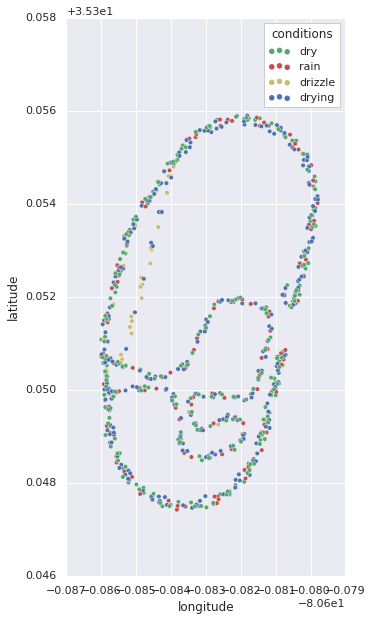

In [10]:
fig, axes = plt.subplots(1,1,figsize=(5,10))
sns.set(style='whitegrid')
sns.scatterplot(x='longitude',y='latitude',hue='conditions',data=df,palette={'dry':'g','rain':'r','drying':'b','drizzle':'y'})



# Separate Data Into Laps

In [11]:
#Separate data by start/finish line, so separate into laps
import math
import numpy as np
sf_inside = [-80.685503,35.352253,0]
sf_outside = [-80.685667,35.352291,0]
sf_inside_above_ground = [-80.685503,35.252253,200]

earth_radius=6371*3280.84 #kilometers to feet
sf_inside_point = [earth_radius*math.cos(sf_inside[1]*math.pi/180)*math.cos(sf_inside[0]*math.pi/180), earth_radius*math.cos(sf_inside[1]*math.pi/180)*math.sin(sf_inside[0]*math.pi/180), earth_radius*math.sin(sf_inside[1]*math.pi/180)]
sf_outside_point = [earth_radius*math.cos(sf_outside[1]*math.pi/180)*math.cos(sf_outside[0]*math.pi/180), earth_radius*math.cos(sf_outside[1]*math.pi/180)*math.sin(sf_outside[0]*math.pi/180), earth_radius*math.sin(sf_outside[1]*math.pi/180)]
sf_inside_above_ground_point = [earth_radius*math.cos(sf_inside_above_ground[1]*math.pi/180)*math.cos(sf_inside_above_ground[0]*math.pi/180), earth_radius*math.cos(sf_inside_above_ground[1]*math.pi/180)*math.sin(sf_inside_above_ground[0]*math.pi/180), earth_radius*math.sin(sf_inside_above_ground[1]*math.pi/180)]

df['x']= earth_radius*np.cos(df['latitude']*math.pi/180)*np.cos(df['longitude']*math.pi/180)
df['y']=earth_radius*np.cos(df['latitude']*math.pi/180)*np.sin(df['longitude']*math.pi/180)
df['z']=earth_radius*np.sin(df['latitude']*math.pi/180)

sf_vector_x = [sf_outside_point[0]-sf_inside_point[0], sf_outside_point[1]-sf_inside_point[1], sf_outside_point[2]-sf_inside_point[2]]
ground_perpendicular_vector_z = [sf_inside_above_ground_point[0]-sf_inside_point[0], sf_inside_above_ground_point[1]-sf_inside_point[1], sf_inside_above_ground_point[2]-sf_inside_point[2]]
travel_vector = np.cross(ground_perpendicular_vector_z,sf_vector_x)

planeD = -1*travel_vector[0]*sf_inside_point[0] - travel_vector[1]*sf_inside_point[1] - travel_vector[2]*sf_inside_point[2]
plane = [travel_vector[0],travel_vector[1],travel_vector[2],planeD]

df['distance_sign'] = np.sign((plane[0]*df['x'] + plane[1]*df['y'] + plane[2]*df['z'] + plane[3])/math.sqrt(plane[0]**2+plane[1]**2+plane[2]**2))
df['distance_sf'] = np.sqrt((df['x']-sf_inside_point[0])**2 + (df['y']-sf_inside_point[1])**2 + (df['z']-sf_inside_point[2])**2)
df['lap']=1

def get_df_sequence(seq,size):
  return(seq.iloc[pos:pos+size] for pos in range(0, len(seq)-1))

df['index_values']=df.index.values
lap_array = np.zeros(df['index_values'].size)
lap_series = pd.Series(lap_array)

distance_array = np.zeros(df['index_values'].size)
distance_series = pd.Series(distance_array)

for i in get_df_sequence(df,2):
  #print('index A: '+str(i.iloc[0].value)+', index B: '+str(i.iloc[1].value))
  if i.iloc[1]['distance_sign'] != i.iloc[0]['distance_sign'] and i.iloc[1]['distance_sign']==-1 and i.iloc[1]['distance_sf']<=600:
    print('index: '+str(i.iloc[1]['index_values']))
    lap_series[i.iloc[1]['index_values']]=lap_series[i.iloc[0]['index_values']]+1
    distance_series[i.iloc[1]['index_values']]=i.iloc[1]['distance_sf']
  else:
    lap_series[i.iloc[1]['index_values']]=lap_series[i.iloc[0]['index_values']]
    distance_previous_point = np.sqrt((i.iloc[1]['x']-i.iloc[0]['x'])**2 + (i.iloc[1]['y']-i.iloc[0]['y'])**2)
    distance_series[i.iloc[1]['index_values']]=distance_previous_point+distance_series[i.iloc[0]['index_values']]

  #print(df.iloc[i.iloc[1]['index_values']]['lap'])

df['lap']=lap_series
df['distance_traveled']=distance_series


index: 27
index: 72
index: 125
index: 175
index: 260
index: 273
index: 302
index: 347
index: 438
index: 484
index: 589
index: 640


In [12]:
df=df.reset_index()
ctdf = df.reset_index().groupby(['distance_traveled','lap'], as_index=False).count()





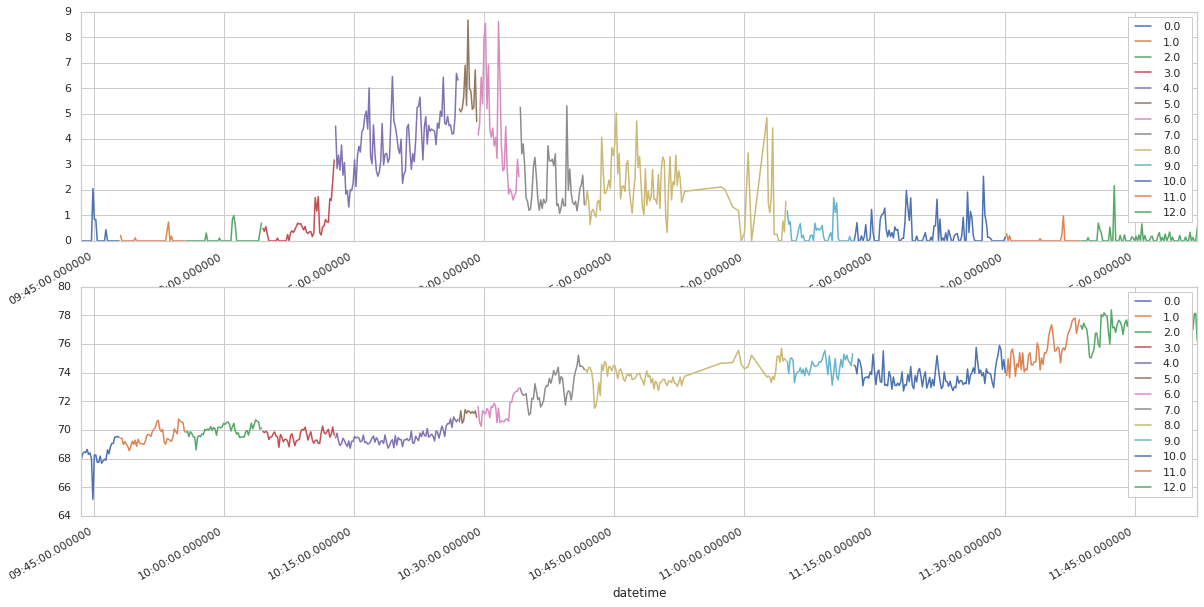

In [14]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
for key, data in df.groupby('lap'):
  #sns.scatterplot(ax=ax, x='distance_traveled',y='temperature',data=df, hue=key)
  data.plot(x='datetime',y='water film height',ax=ax[0], label=key)
  data.plot(x='datetime',y='temperature',ax=ax[1], label=key)

7.0
8.0
9.0
10.0
11.0
12.0


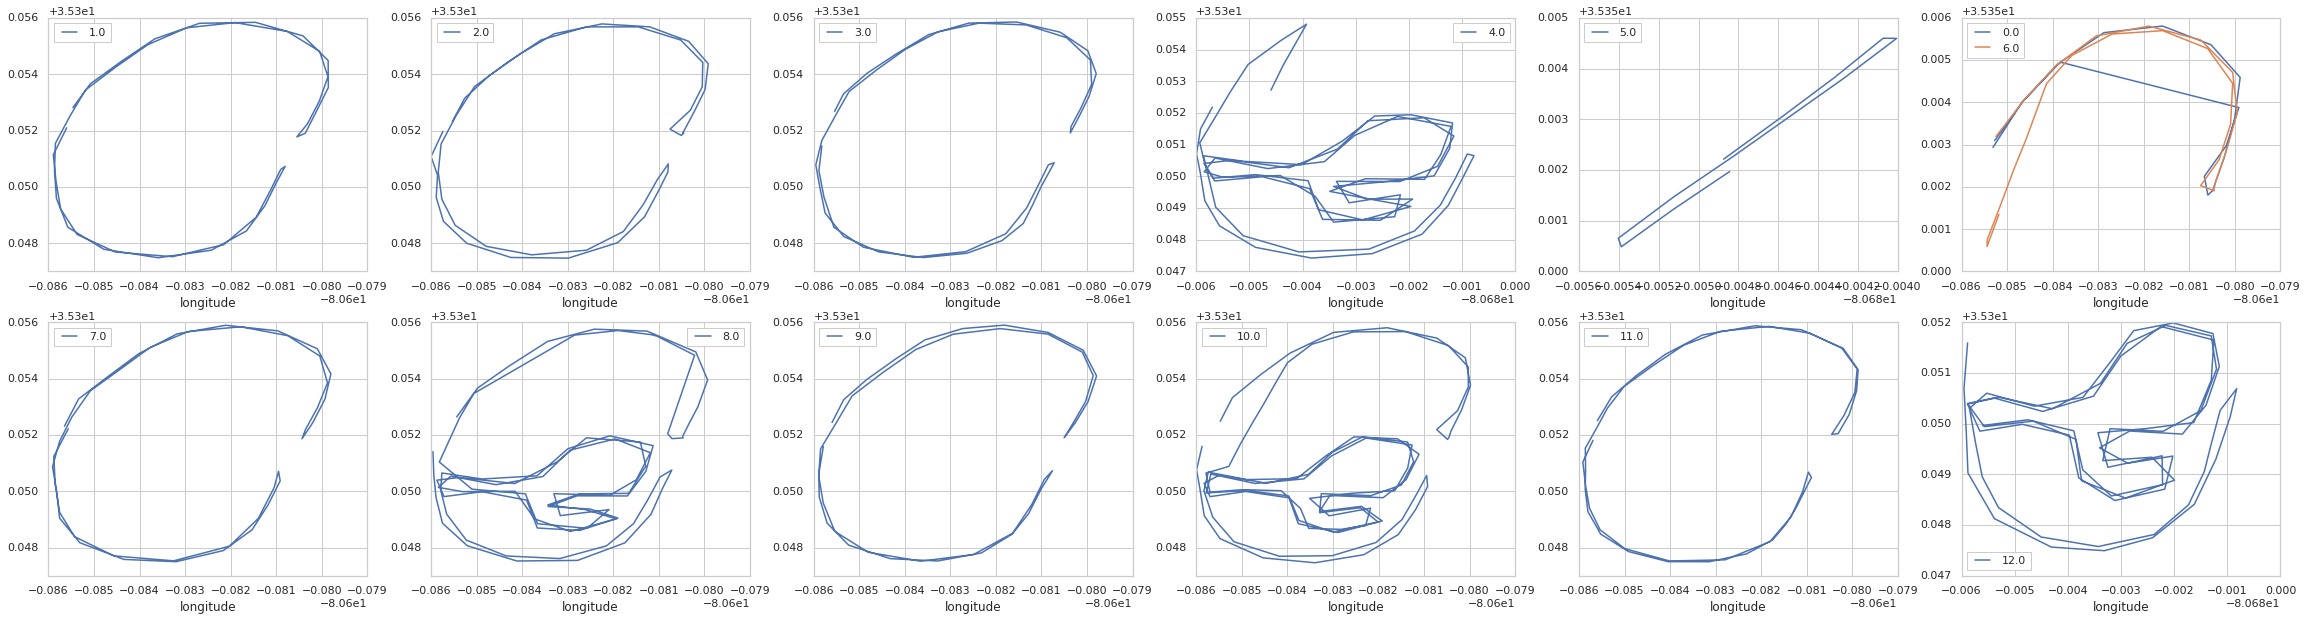

In [15]:
fig, ax = plt.subplots(2,6,figsize=(40,10))
for key, data in df.groupby('lap'):
  #sns.scatterplot(ax=ax, x='distance_traveled',y='temperature',data=df, hue=key)
  if key<7:
    
    plot_axis=ax[0,int(key)-1]
  else:
    print(key)
    plot_axis=ax[1,int(key)-7]
  data.plot(ax=plot_axis,x='longitude',y='latitude', label=key)

# Plot MARWIS Track Surface Measurements
* Temperature
* Water Film Height
* Humidity
* Dewpoint

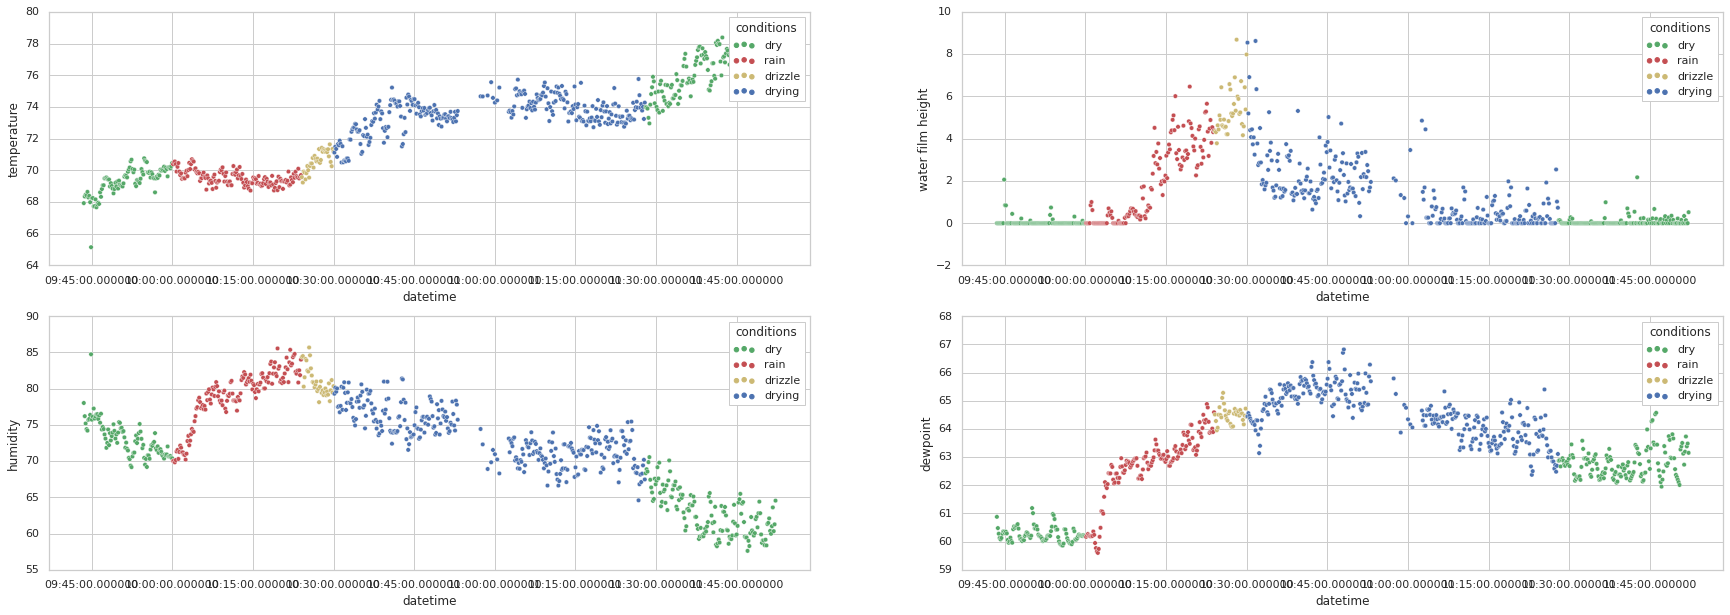

In [16]:

from datetime import datetime
fig, axes = plt.subplots(2,2,figsize=(30,10))
sns.set(style='whitegrid')
sns.scatterplot(ax=axes[0,0], x='datetime',y='temperature',hue='conditions',data=df,palette={'dry':'g','rain':'r','drying':'b','drizzle':'y'})

sns.scatterplot(ax=axes[0,1],x='datetime',y='water film height',hue='conditions',data=df,palette={'dry':'g','rain':'r','drying':'b','drizzle':'y'})
sns.scatterplot(ax=axes[1,0], x='datetime',y='humidity',hue='conditions',data=df,palette={'dry':'g','rain':'r','drying':'b','drizzle':'y'})
sns.scatterplot(ax=axes[1,1],x='datetime',y='dewpoint',hue='conditions',data=df,palette={'dry':'g','rain':'r','drying':'b','drizzle':'y'})